In [4]:
import numpy as np 
import pandas as pd 

In [5]:
import matplotlib.pyplot as plt

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [ ]:
data = pd.read_csv("Sales data for selected products.csv")

In [ ]:
data['ORDER_ITEM_NAME'].value_counts()

In [ ]:
data.dropna(inplace = True)

In [ ]:
item1 = data[data['ORDER_ITEM_NAME'] == 'Jowar & Ragi Gluten-free bread (700 g)']

In [ ]:
item1.isnull().value_counts()

In [ ]:
item1.to_csv('item1.csv')

In [6]:
df = pd.read_csv('item1.csv', parse_dates=['DELIVERY_DATE'])
df.head(3)

,Unnamed: 0,ORDER_ITEM_NAME,DELIVERY_DATE,Quantity,Distinct Orders
0,137,Jowar & Ragi Gluten-free bread (700 g),2021-12-01,10.0,10.0
1,52,Jowar & Ragi Gluten-free bread (700 g),2021-12-02,7.0,7.0
2,0,Jowar & Ragi Gluten-free bread (700 g),2021-12-03,8.0,8.0


In [8]:
print (df.describe())
print ("=============================================================")
print (df.dtypes)

       Unnamed: 0   Quantity  Distinct Orders
count   31.000000  31.000000        31.000000
mean   214.032258   6.225806         6.129032
std    130.405645   2.917872         2.906796
min      0.000000   1.000000         1.000000
25%     93.500000   4.000000         4.000000
50%    228.000000   6.000000         6.000000
75%    324.500000   8.000000         8.000000
max    426.000000  13.000000        13.000000
Unnamed: 0                  int64
ORDER_ITEM_NAME            object
DELIVERY_DATE      datetime64[ns]
Quantity                  float64
Distinct Orders           float64
dtype: object


Lets segregate the Date & Close price to analyze them separately

In [9]:
df1 = df[['DELIVERY_DATE','Quantity']]
df1.head(3)

,DELIVERY_DATE,Quantity
0,2021-12-01,10.0
1,2021-12-02,7.0
2,2021-12-03,8.0


In [10]:
# Setting the Date as Index
df_ts = df1.set_index('DELIVERY_DATE')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print ("========================")
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
               Quantity
DELIVERY_DATE          
2021-12-01         10.0
2021-12-02          7.0
2021-12-03          8.0
               Quantity
DELIVERY_DATE          
2021-12-29          6.0
2021-12-30          4.0
2021-12-30          4.0


In [11]:
df_ts.dtypes

Quantity    float64
dtype: object

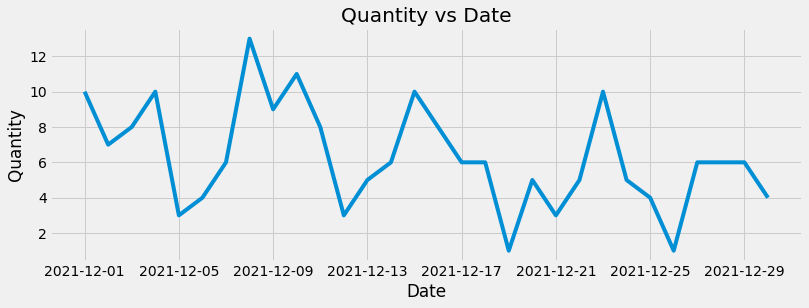

In [71]:
import matplotlib.pyplot as plt

# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("fivethirtyeight")

# setting figure size to 12, 4
plt.figure(figsize=(12, 4))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Quantity vs Date")

# plotting the "A" column alone
plt.plot(df_ts['Quantity'])


In [14]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)
    

In [15]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = pd.Series(df_ts['Quantity'])
#test_stationarity(ts)
ts.isnull().sum()

0

**Conclusion **

The Test Statistics value is Much higher than critical value. So we can't reject the Null Hypothesis.

Hence Statistically (and obviously from the plot) the Time series is Non-Stationary


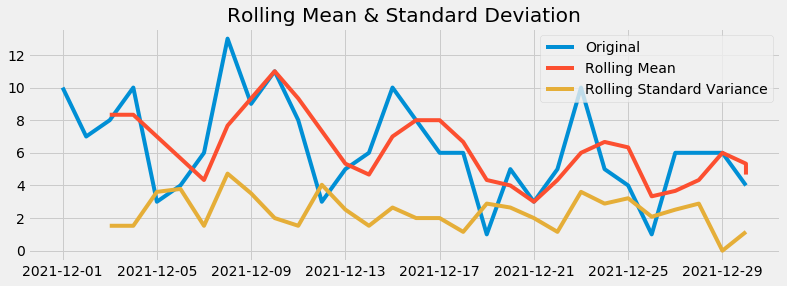

In [76]:
rolmean = ts.rolling(window=3).mean()
rolvar = ts.rolling(window=3).std()
plt.figure(figsize=(12, 4))
plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [19]:
# Lets Resample the data by Month and analyze again
df_ts_m = df_ts.resample('D').mean()
print (type(df_ts_m))
print (df_ts_m.head(3))

<class 'pandas.core.frame.DataFrame'>
               Quantity
DELIVERY_DATE          
2021-12-01         10.0
2021-12-02          7.0
2021-12-03          8.0


In [20]:
tsm = df_ts_m['Quantity']
print (type(tsm))

<class 'pandas.core.series.Series'>


In [21]:
# Stationarity Check
test_stationarity(tsm)

## reject the null hupothesis as the Test statistic< p-value , hence the data is stationay

Results of Dickey-Fuller Test:
Test Statistic                 -0.146480
p-value                         0.944608
#lags Used                      6.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


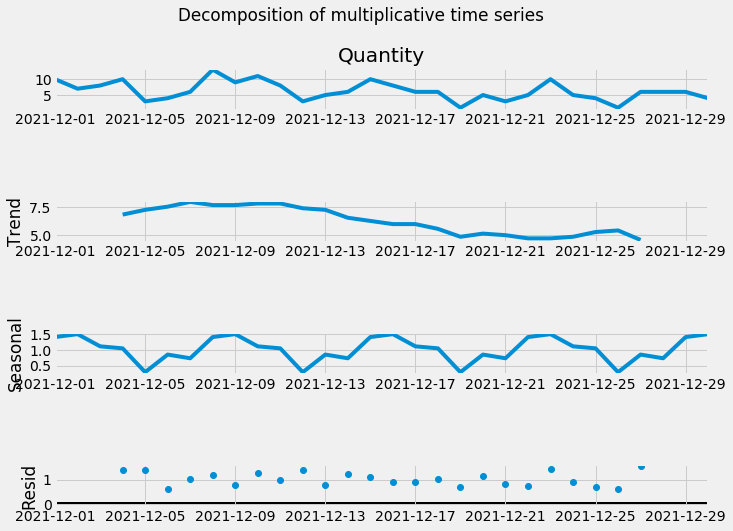

In [22]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

**Conclusion**

This we see a somewhat clarity on the Seasonality graph

In [29]:
# lets try to make the "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
#Stationarity Check
test_stationarity(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                -6.837569e+00
p-value                        1.825908e-09
#lags Used                     5.000000e+00
Number of Observations Used    2.300000e+01
Critical Value (1%)           -3.752928e+00
Critical Value (5%)           -2.998500e+00
Critical Value (10%)          -2.638967e+00
dtype: float64


**Conclusion**

Now the Test Statistics is less than Critical value - rendering that The time series is Stationary now. 
We can use it now in Forecasting Techniques like ARIMA

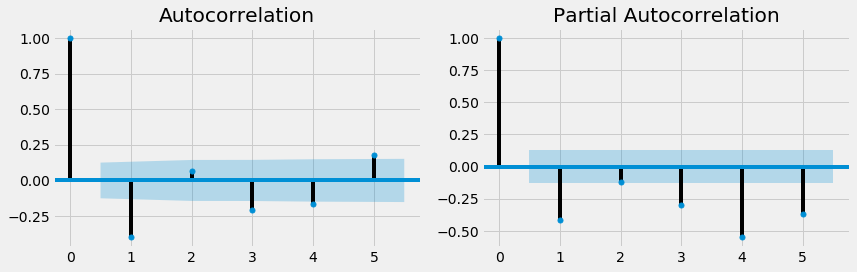

In [36]:
# Let's plot ACF & PACF graphs to visualize AR & MA components

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=5, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=5, ax=axes[1], alpha=0.5)
plt.tight_layout()

**End - Note**

This is my First Public Kernel .

Please upvote of if you find it helpful .

Suggest\Comment to improvise. 

Thanks !


In [37]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_ts_m,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:195.4808114714455
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:108.23196281987273
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:95.32083114939014
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:29.55937627402448
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:91.63759784966545
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:89.38196030895546
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:33.73862214810791
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:31.558682984121518
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:171.95841543104473
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:95.26303192355793
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:86.26050303530508
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:19.50815616229717
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:89.29314826613154
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:83.52156026382161
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:32.667094077807555
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:21.45742074325716
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:150.44844859619906
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:84.84

In [44]:
#Fit the model with the best params.
#SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:294.6493550920779


#The above output suggests that ARIMA(1, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value: 14.31
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(df_ts_m,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1812     99.376     -0.002      0.999    -194.954     194.591
ma.L1         -1.1242   1509.423     -0.001      0.999   -2959.540    2957.291
ma.S.L12       0.4203   4213.805   9.97e-05      1.000   -8258.485    8259.325
sigma2         0.3702    285.884      0.001      0.999    -559.952     560.693


In [45]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Quantity   No. Observations:                   30
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.159
Date:                            Wed, 26 Jan 2022   AIC                             14.318
Time:                                    22:06:05   BIC                             10.713
Sample:                                12-01-2021   HQIC                             7.070
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1812     99.376     -0.002      0.999    -194.954     194.591
ma.L1         -1.1242   1509.423     -0.001      0.999   -2959.540    2957.291
ma.S.L12       0.4203   4213.805   9.97e-05      1.000   -8258.485    8259.325
sigma2         0.3702    285.884      0.001      0.999    -559.952     560.693
===================================================================================
Ljung-Box (Q):                        1.87   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.39   Prob(JB):                         0.87
Heteroskedasticity (H):                nan   Skew:                            -0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.08e+17. Standard errors may be unstable.
"""

In [66]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 30th of Dec 2021 .
pred = results.get_prediction(start=pd.to_datetime('2021-12-30'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()



In [67]:
print(pred_ci)

               lower Quantity  upper Quantity
DELIVERY_DATE                                
2021-12-30           3.552289         6.27053


In [68]:
pred.predicted_mean

DELIVERY_DATE
2021-12-30    4.911409
Freq: D, dtype: float64